# GPs with Gaussian noise -- Marginal Likelihood Implementation

The `gp.Marginal` class implements the more common case of GP regression:  the observed data are the sum of a GP and Gaussian noise.  `gp.Marginal` has a `marginal_likelihood` method, a `conditional` method, and a `predict` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

The observations $y$ are the unknown function plus noise

$$
\begin{aligned}
  \epsilon &\sim N(0, \Sigma) \\
  y &= f(x) + \epsilon \\
\end{aligned}
$$

Notice that the Gaussian noise, $\Sigma$, does not need to white, $\sigma^2 \mathbf{\mathrm{I}}$. 

## The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}\log(\mathbf{K}_{xx} + \boldsymbol\Sigma)
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.  Some sample code would be,

```python
import numpy as np
import pymc3 as pm

# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None]

with pm.Model() as marginal_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # The scale of the white noise term can be provided,
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)
    
    # OR a covariance function for the noise can be given
    # noise_l = pm.Gamma("noise_l", alpha=2, beta=2)
    # cov_func_noise = pm.gp.cov.Exponential(1, noise_l) + pm.gp.cov.WhiteNoise(sigma=0.1)
    # y_ = gp.marginal_likelihood("y", X=X, y=y, noise=cov_func_noise)
```

## The `.conditional` distribution

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  Using the same `gp` object defined above, 

```python
# vector of new X points we want to predict the function at
Xnew = np.linspace(0, 2, 100)[:, None]

with marginal_gp_model:
    f_star = gp.conditional("f_star", Xnew=Xnew)
    
    # or to predict the GP plus noise
    y_star = gp.conditional("y_star", Xnew=Xnew, pred_noise=True)
```
If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  For more information on building additive GPs, see the main documentation page.  For an example, see the Mauna Loa CO$_2$ notebook.  

## Making predictions

The `.predict` method returns the conditional mean and variance of the `gp` given a `point` as NumPy arrays.  The `point` can be the result of `find_MAP` or a sample from the trace.  The `.predict` method can be used outside of a `Model` block.  Like `.conditional`, `.predict` accepts `given` so it can produce predictions from components of additive GPs.

```python
# The mean and full covariance
mu, cov = gp.predict(Xnew, point=trace[-1])

# The mean and variance (diagonal of the covariance)
mu, var = gp.predict(Xnew, point=trace[-1],  diag=True)

# With noise included
mu, var = gp.predict(Xnew, point=trace[-1],  diag=True, pred_noise=True)
```

## Example: Regression with white, Gaussian noise

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 4395
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

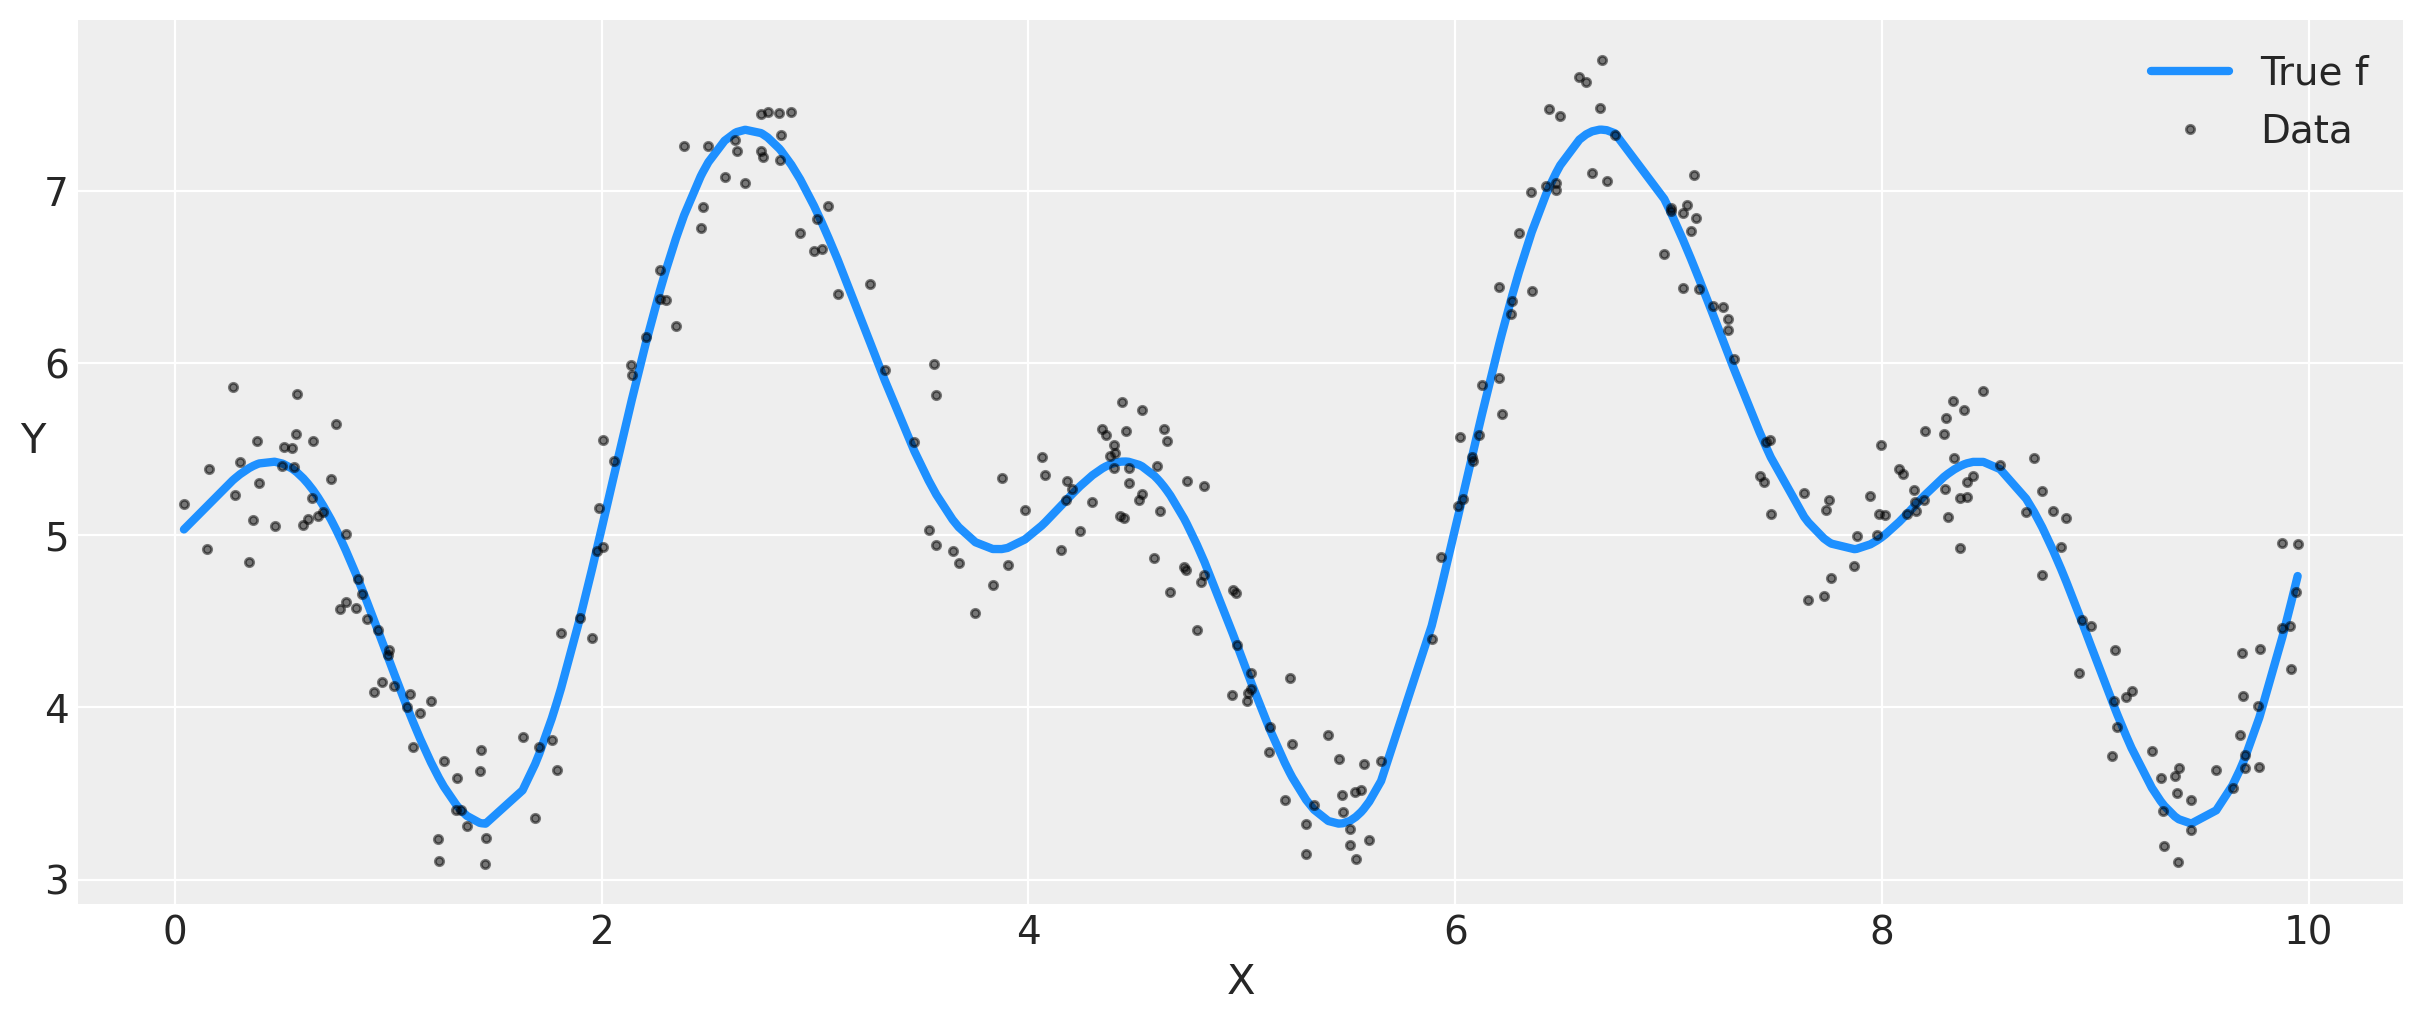

In [3]:
n = 300  # The number of data points
X = (
    10 * np.sort(rng.uniform(size=n))[:, None]
)  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 3.0
period_true = 4.0
ell_decay_true = 10.0

# the Periodic covariance function models a repeating pattern
cov_func = eta_true ** 2 * pm.gp.cov.Periodic(1, period=period_true, ls=ell_true) + 1.0

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC is built on top of Aesara
f_true = rng.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 0.25
y = f_true + sigma_true * rng.normal(size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("Y", rotation=0)
plt.legend();

In [4]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sd=5)
    # a more informative prior on the period
    period = pm.Gamma("period", mu=3, sd=0.5)

    # decay lengthscale, we don't know if periodic process is periodic indefinitely in either direction
    # The product of the periodic kernel and the ExpQuad will allow the process to become less periodic over time.
    ell_d = pm.Gamma("ell_d", alpha=2, beta=0.5)

    cov = (
        eta ** 2 * pm.gp.cov.Periodic(1, period=period, ls=ell) * pm.gp.cov.ExpQuad(1, ls=ell_d)
        + 1.0
    )
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfNormal("sigma", sd=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)

    trace = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/bill/development/pymc/pymc/model.py:950: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, period, ell_d, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 389 seconds.
The acceptance probability does not match the target. It is 0.9525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


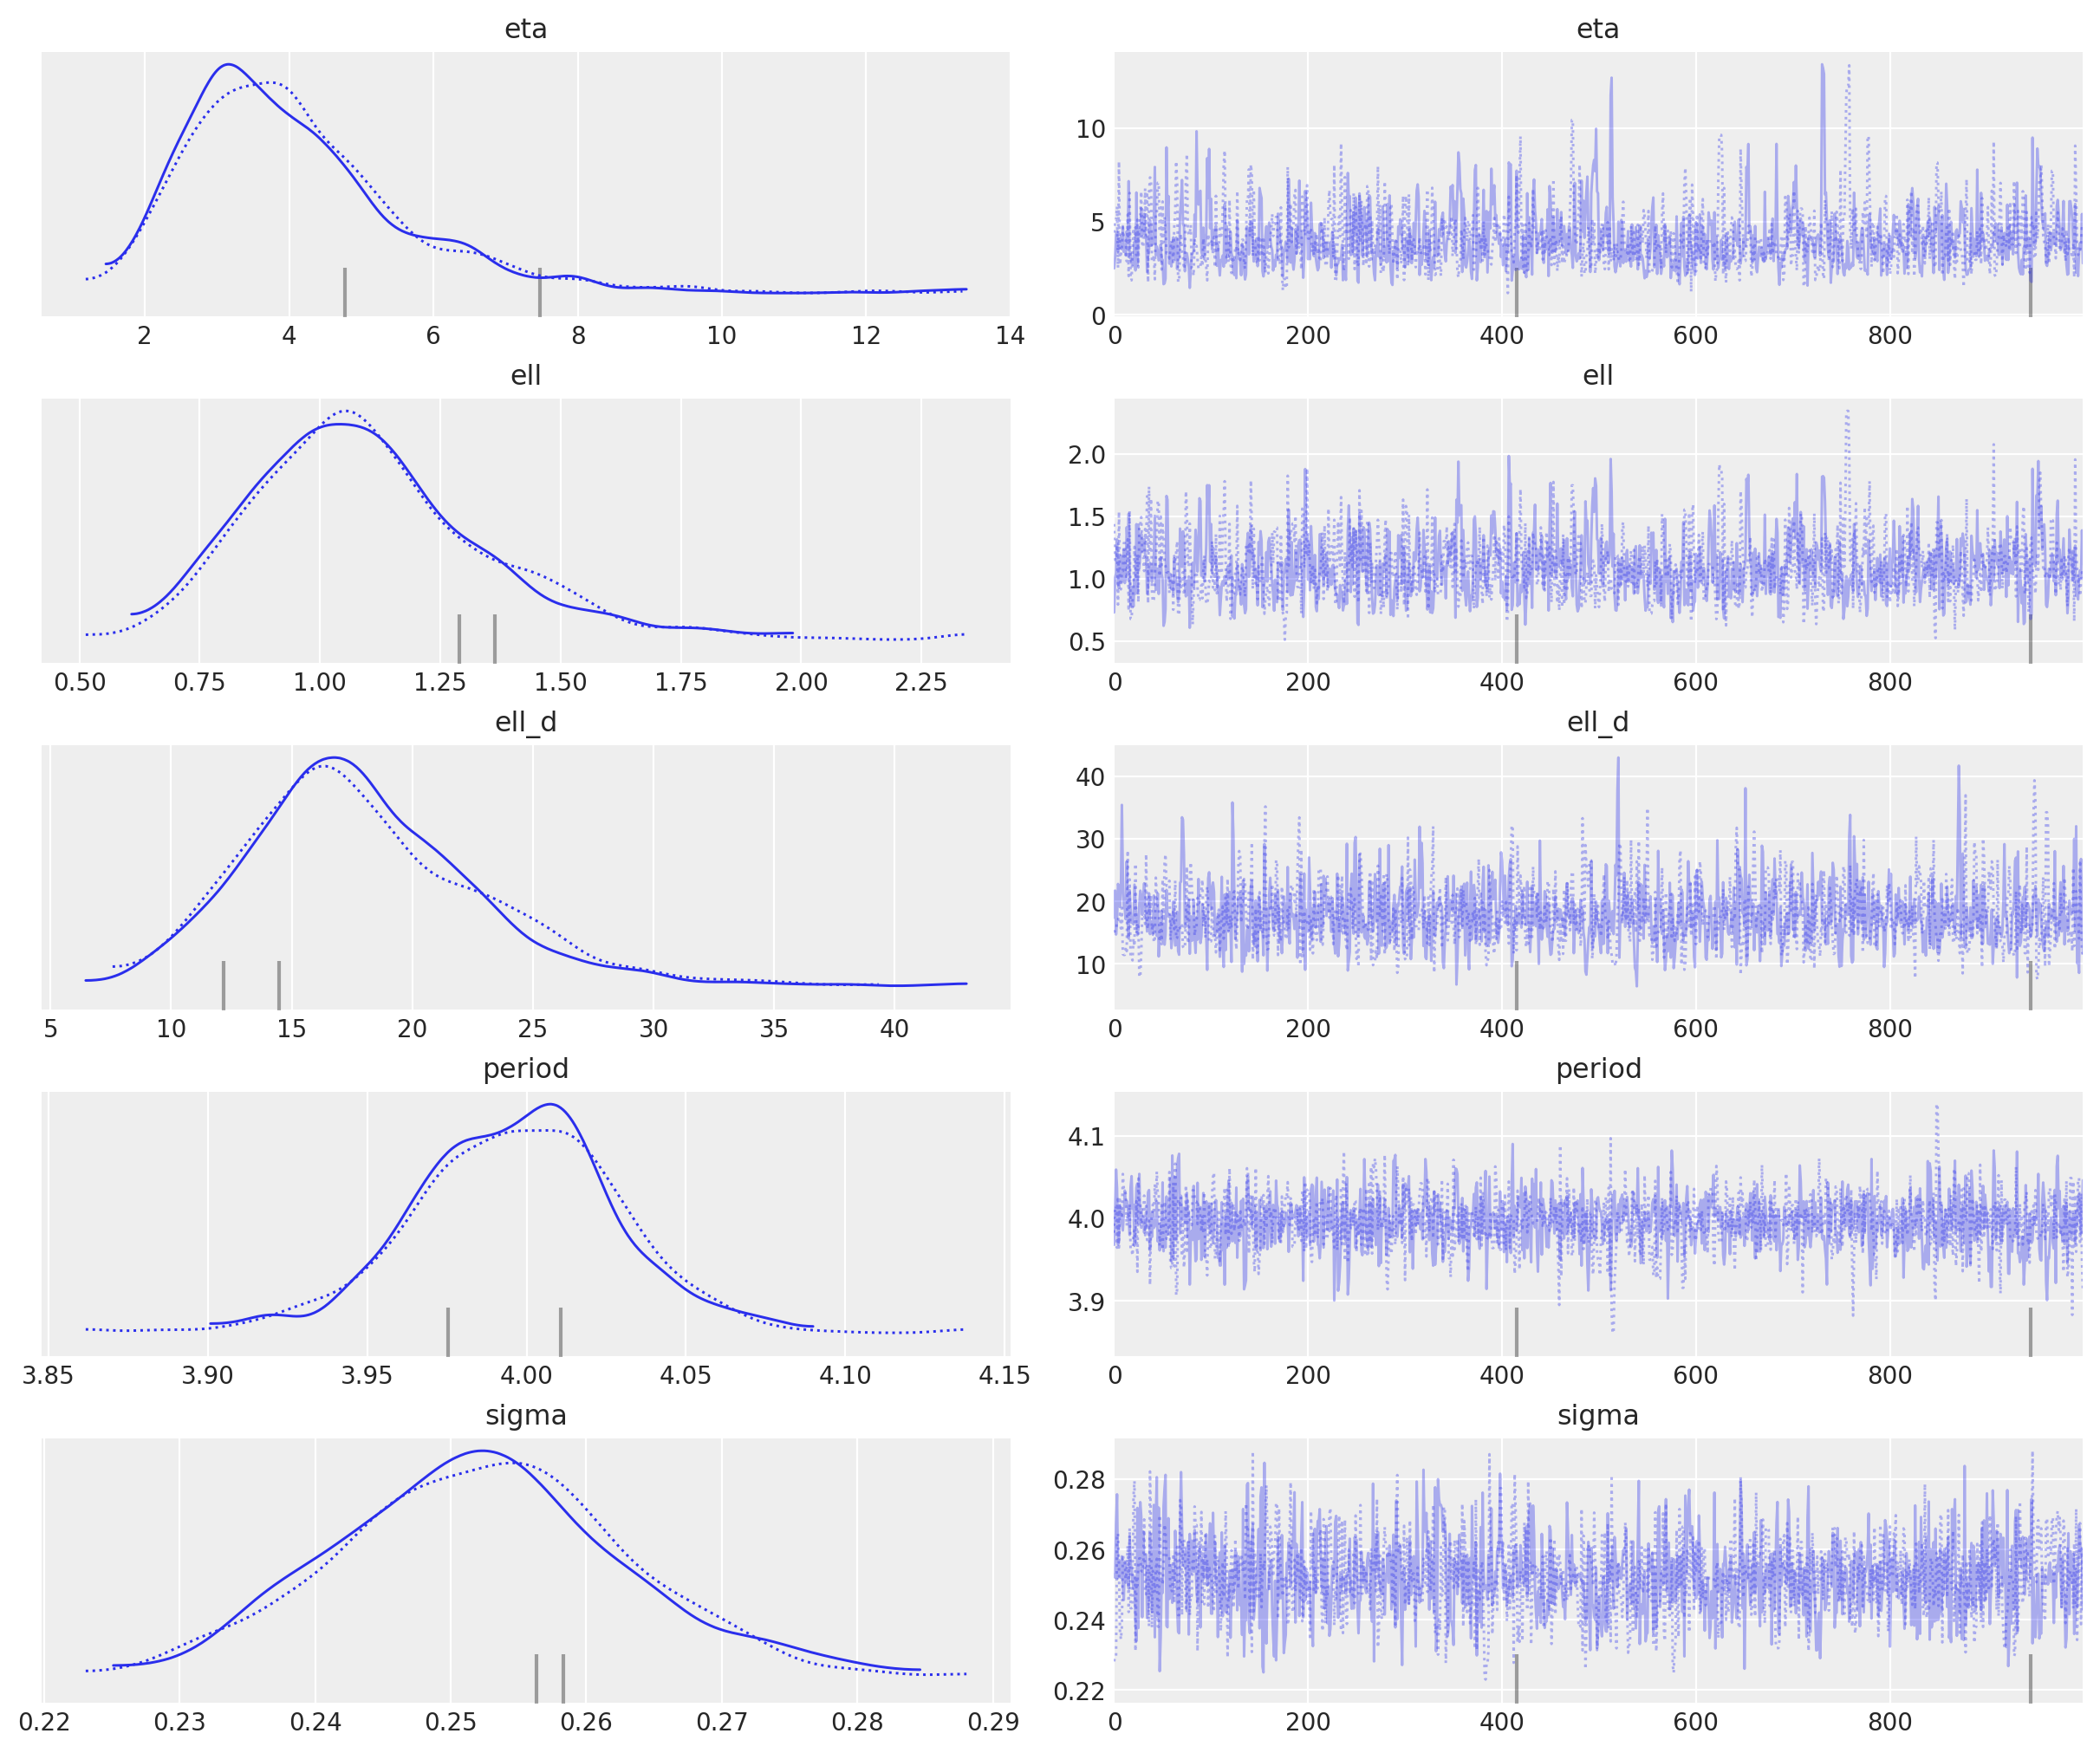

In [5]:
az.plot_trace(trace, var_names=["eta", "ell", "ell_d", "period", "sigma"]);

To help demonstrate the `Marginal.conditional` and `Marginal.predict` methods, we use the MCMC samples to take the MAP estimate.

In [6]:
map_estimate = {name: np.mean(draws.values) for name, draws in trace.posterior.data_vars.items()}

# collect the results into a pandas dataframe to display
pd.DataFrame(
    {
        "Parameter": ["ell", "eta", "period", "sigma"],
        "Value at MAP": [
            float(map_estimate["ell"]),
            float(map_estimate["eta"]),
            float(map_estimate["period"]),
            float(map_estimate["sigma"]),
        ],
        "True value": [ell_true, eta_true, period_true, sigma_true],
    }
)

,Parameter,Value at MAP,True value
0,ell,1.099685,1.00
1,eta,4.087428,3.00
2,period,3.996377,4.00
3,sigma,0.252335,0.25


### Using `.conditional`

In [7]:
X_new = np.linspace(-4, 27, 600)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `map_estimate`
# Even with the MAP estimate, the uncertainty in the estimates is still fairly accurate
with model:
    pred_samples = pm.sample_posterior_predictive([map_estimate], var_names=["f_pred"], samples=500)

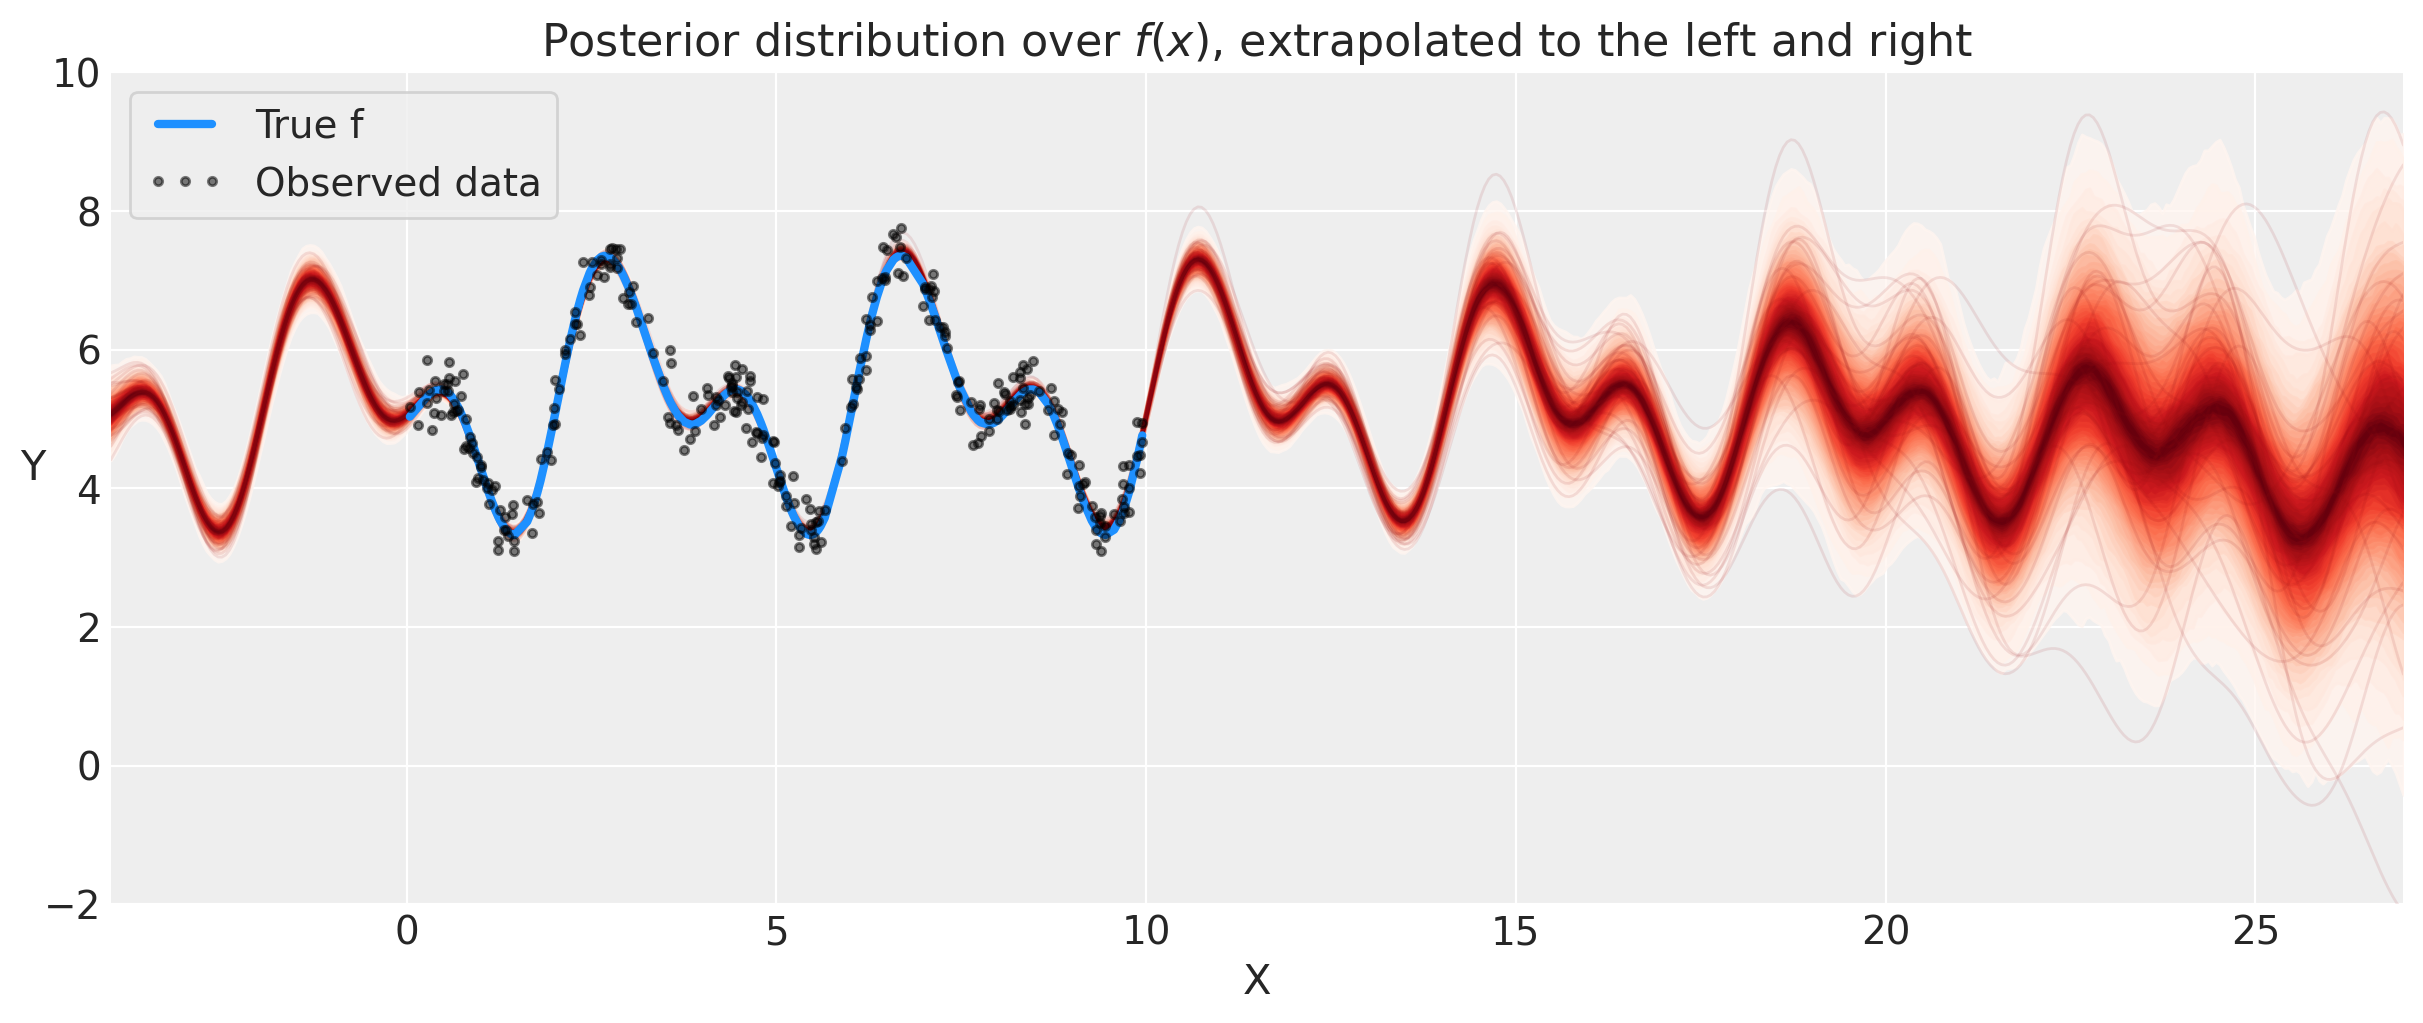

In [8]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

f_pred = pred_samples.posterior_predictive.f_pred.stack({"f_pred": ["chain", "draw"]}).values
plot_gp_dist(ax, f_pred.T, X_new)

plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

plt.xlabel("X")
plt.ylabel("Y", rotation=0)
plt.xlim([-4, 27])
plt.ylim([-2, 10])
plt.title("Posterior distribution over $f(x)$, extrapolated to the left and right")
plt.legend(frameon=True, numpoints=3, loc="upper left");

Prediction also aligns closely with `gp.Latent`.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we set this flag to `True`.  This will include samples of the noise noise in the predictions.

In [9]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([map_estimate], var_names=["y_pred"], samples=2000)

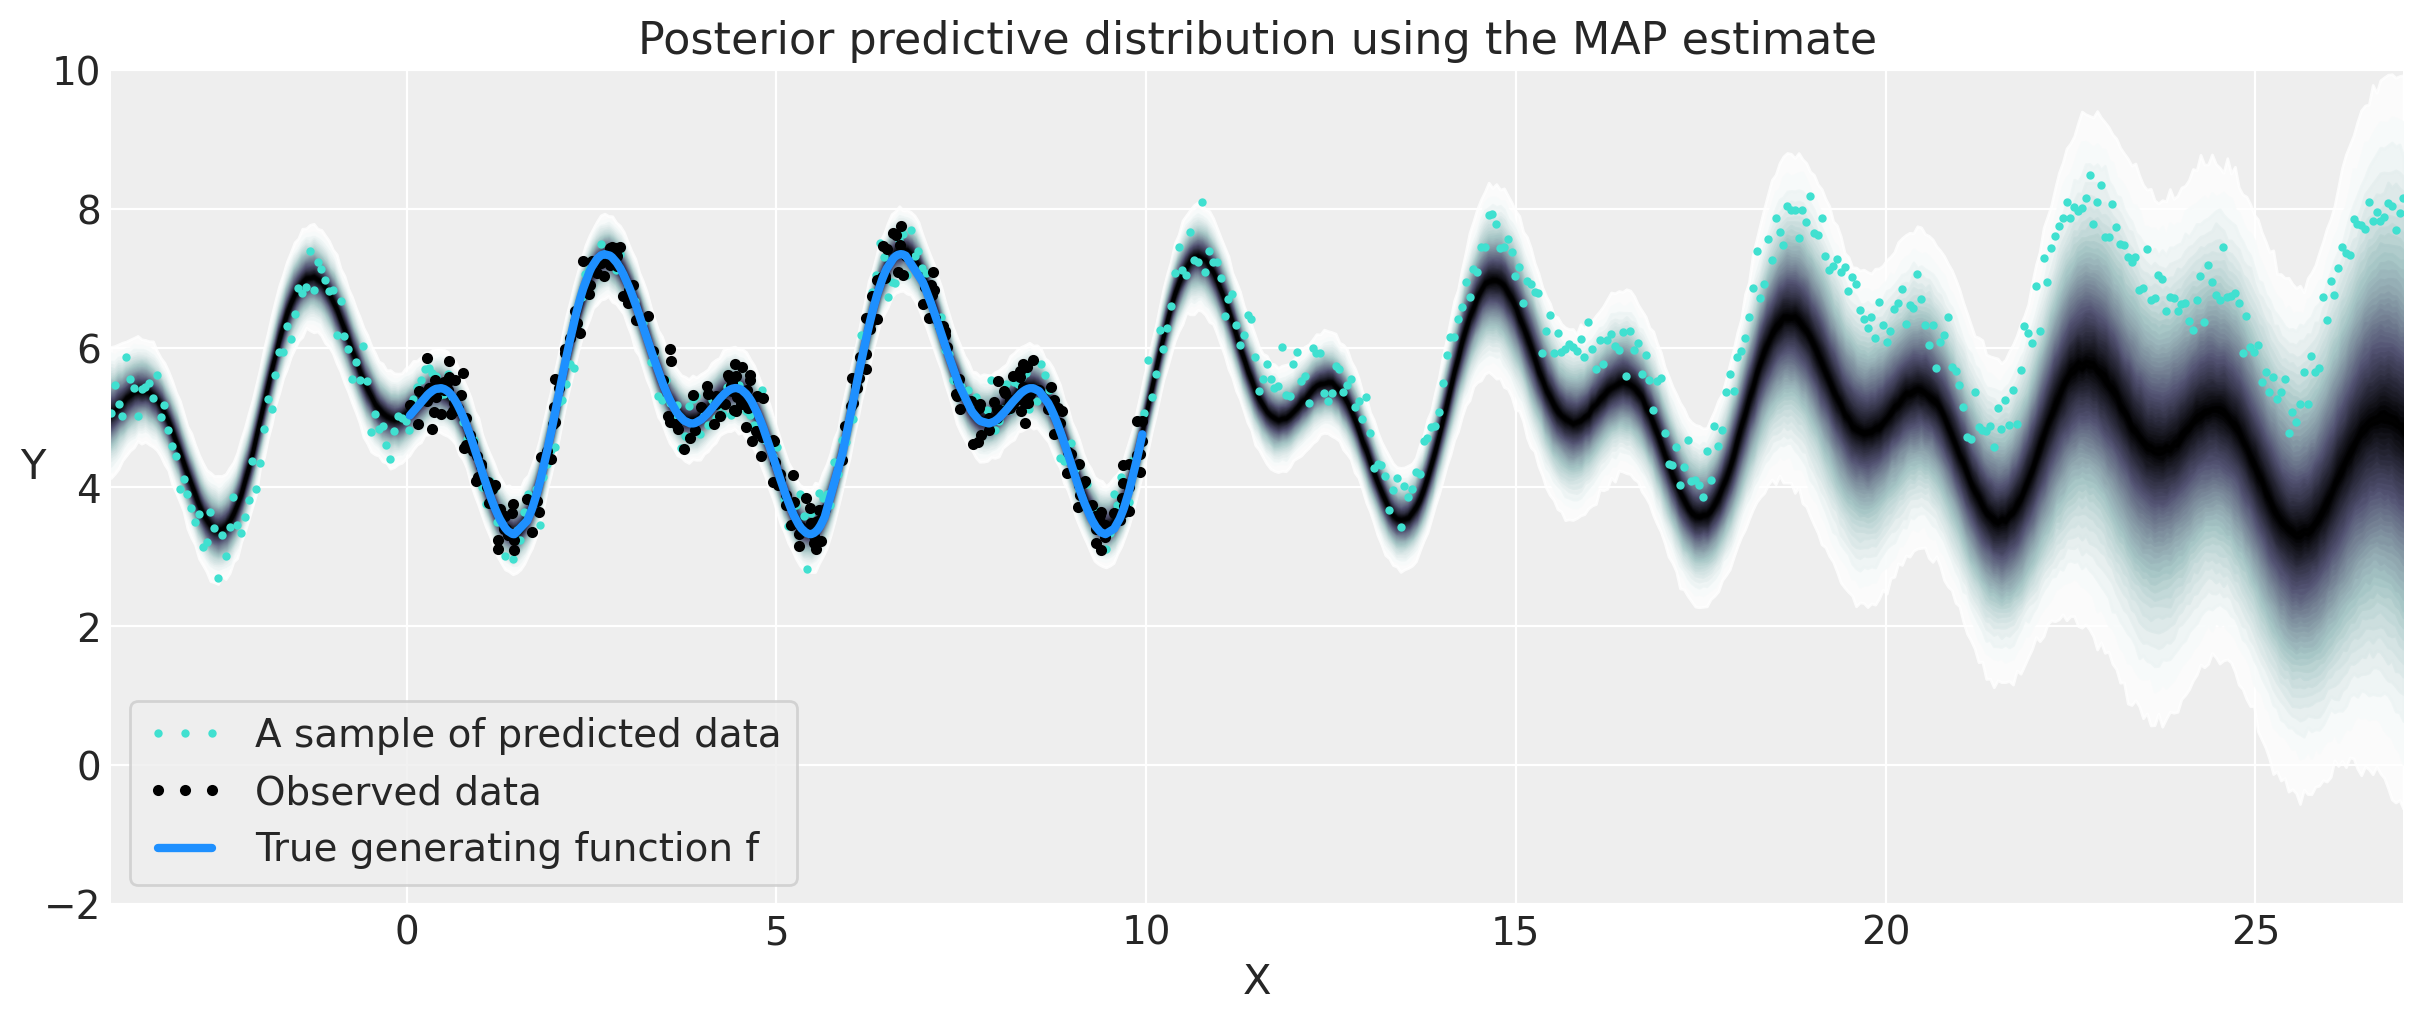

In [10]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

y_pred = y_samples.posterior_predictive.y_pred.stack({"y_pred": ["chain", "draw"]}).values
plot_gp_dist(ax, y_pred.T, X_new, plot_samples=False, palette="bone_r")

# overlay a scatter of one draw of random points from the posterior predictive distribution, "one data set"
plt.plot(
    X_new,
    y_pred[:, 400],
    "o",
    color="turquoise",
    ms=2,
    label="A sample of predicted data",
)

plt.plot(X, y, "ok", ms=3, alpha=1.0, label="Observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="True generating function f")

plt.xlabel("X")
plt.ylabel("Y", rotation=0)
plt.xlim([-4, 27])
plt.ylim([-2, 10])
plt.title("Posterior predictive distribution using the MAP estimate")
ax.set_ylabel("Y", rotation=0)
plt.legend(frameon=True, numpoints=3, loc="lower left");

Notice that the posterior predictive density is wider than the conditional distribution of the noiseless function, and reflects the predictive distribution of the noisy data, which is marked as black dots.  The light colored dots don't follow the spread of the predictive density exactly because they are a single draw from the posterior of the GP plus noise.

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

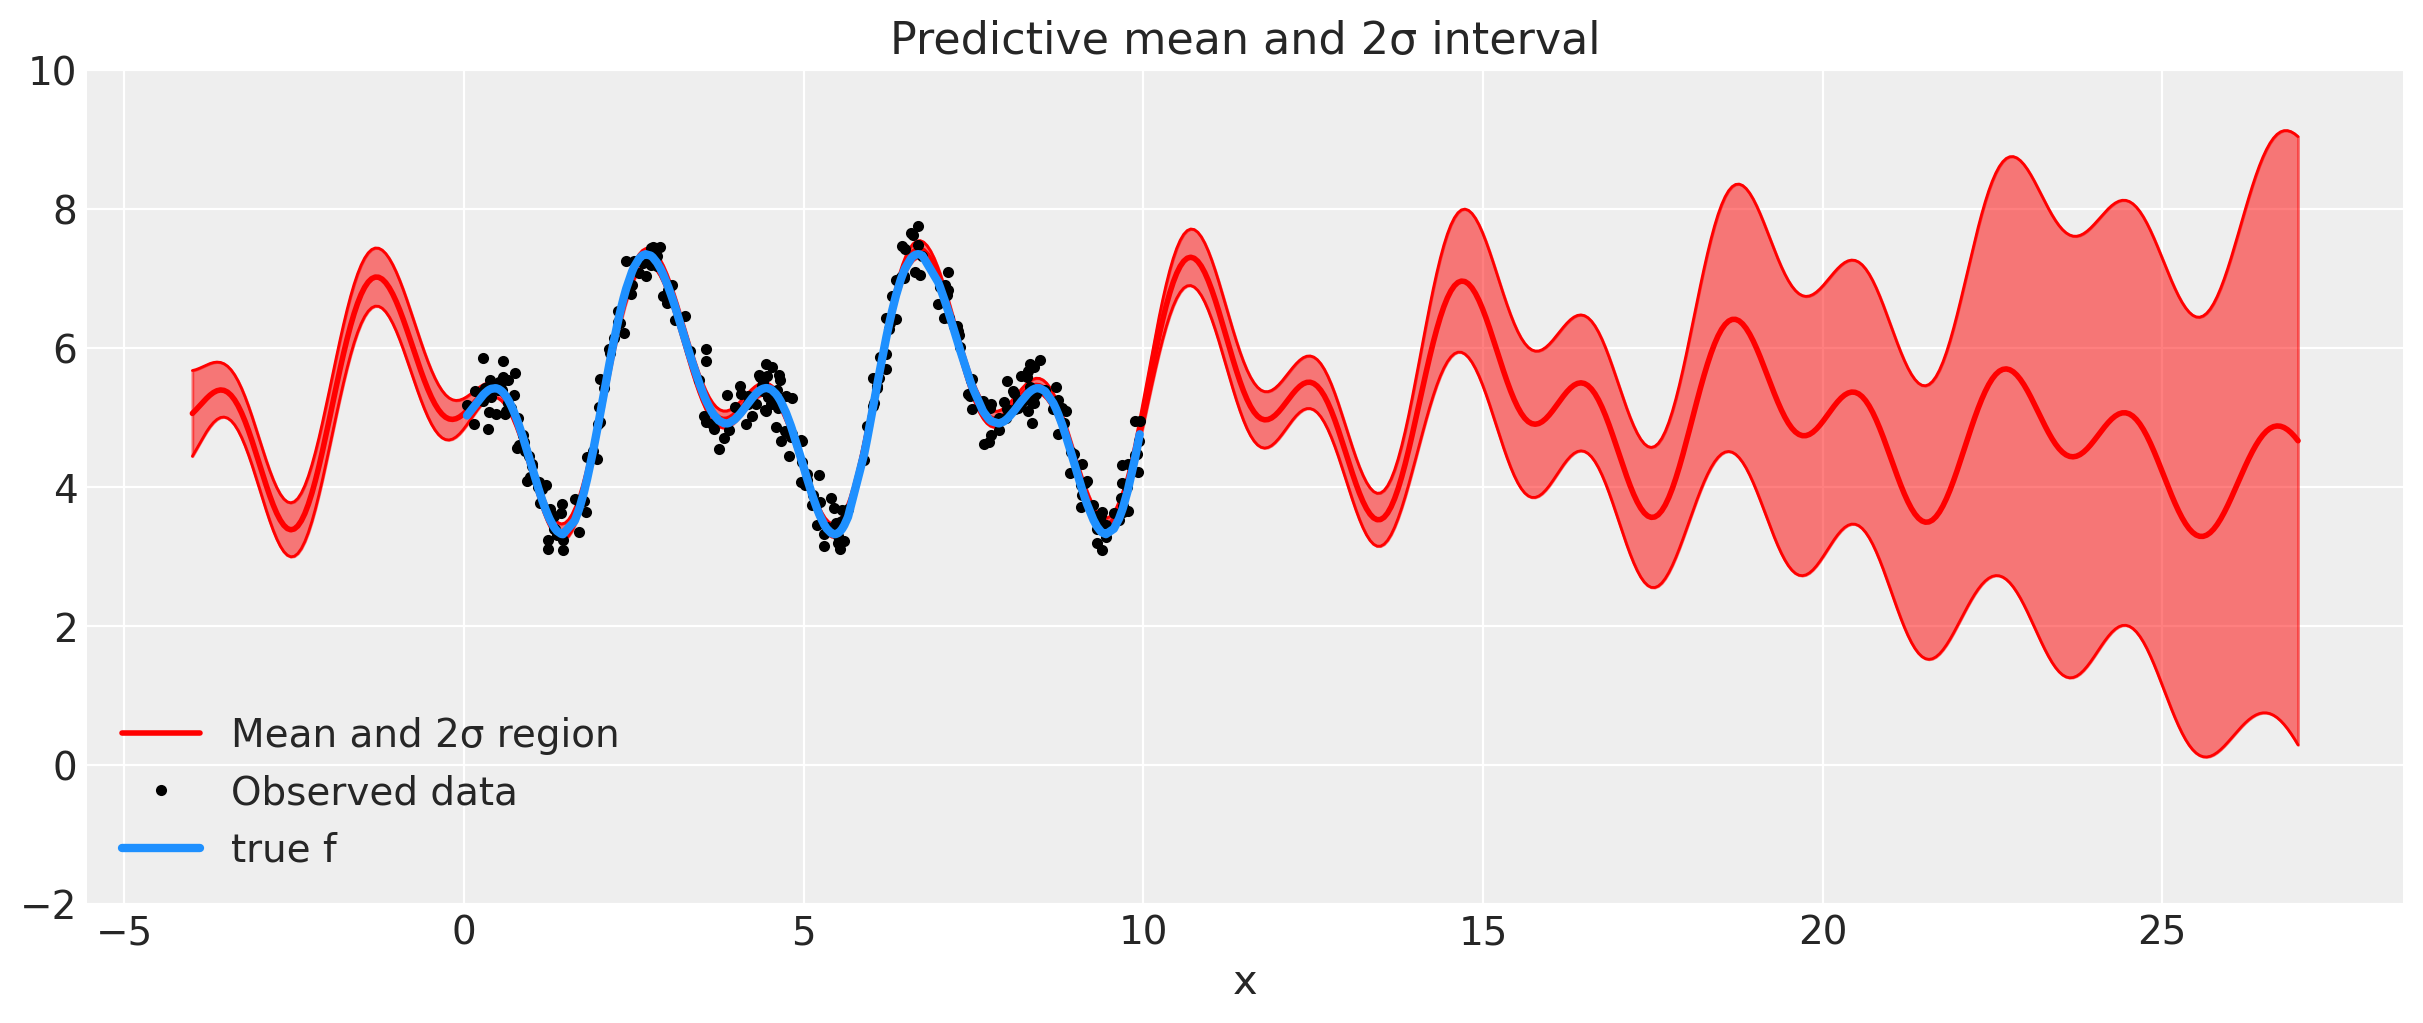

In [11]:
with model:
    mu, var = gp.predict(X_new, point=map_estimate, diag=True)
    sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="Mean and 2σ region")
plt.plot(X_new, mu + 2 * sd, "r", lw=1)
plt.plot(X_new, mu - 2 * sd, "r", lw=1)
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="Observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-2, 10])
plt.title("Predictive mean and 2σ interval")
plt.legend();

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

ModuleNotFoundError: No module named 'watermark'